In [9]:
from script.model import RES
from script.train_new import train_edge_pat_weight
from script.utils import genimg, crop_2d, MaxMinNormalization
from script.utils import calculate_ssim_psnr, show_image, show_images, calculate_entropy
from script.train import train, train_record
from script.edge_loss import edgeconvloss, EdgeConvloss
from script.perceptual_loss import VGGPerceptualLoss

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from PIL import Image
import cv2
from skimage.exposure import match_histograms
import os

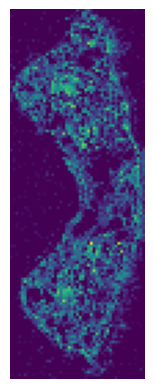

In [21]:
msi_data = np.load(f'test data/msi_data.npy')
show_image(msi_data)

In [ ]:
# define additional function for training. Users may add their own functions such as loss recording, etc.

def edge_pat_w(model, msi_data
                , runname
                , device
                , factor=20
                , num_epochs=2000
                , interval_epochs =200
                , lr=0.0005
                , initial_patience: int = 5
                , weight: int = 20
                , return_: bool = True
                ):
    print('preparing data')
    # preprare data, transform to torch tensor
    opt_data = np.array(Image.open(f'test data/opt-2.png').convert("RGB"))
    
    # opt-2.png is 20x the size of msi_data.
    if factor != 20:
      opt_data = cv2.resize(opt_data, None, fx=factor/20, fy=factor/20, interpolation=cv2.INTER_AREA)
    opt_data = np.moveaxis(opt_data, -1, 0)
    msi_upscaled = cv2.resize(msi_data, None, fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)
    opt_img = torch.tensor(opt_data, dtype=torch.float32).unsqueeze(0)
    msi_img = torch.tensor(msi_upscaled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # normalize
    opt_img = opt_img / 255
    msi_img = msi_img / torch.max(msi_img) * 20

    # examine images
    figs = [
          msi_data
        , msi_upscaled
        , np.moveaxis(opt_data, 0, -1)
       ]

    titles = ['MSI', 'MSIupscaled' ,'Optical']

    _, axes = plt.subplots(1,3,subplot_kw = {"xticks":[],"yticks":[]}
                             , figsize = (6, 6)
                            )
    for i, ax in enumerate(axes.flat):
        ax.imshow(figs[i])
        ax.set_title('{}'.format(titles[i]), fontsize = 20, color = 'black')
    plt.tight_layout()
    plt.show()

    # training
    trained_model, loss_df = train_edge_pat_weight(model, opt_img, msi_img
                                , device=device
                                , num_epochs=num_epochs
                                , interval_epochs=interval_epochs
                                , lr=lr
                                , initial_patience=initial_patience
                                , weight=weight
                                )
    # save checkpoint and npy
    torch.save(trained_model.state_dict()
                , f'{runname}-{num_epochs}epochs-x{factor}.pth')
    fusion = genimg(model, opt_img)
    matched = match_histograms(fusion, msi_upscaled, channel_axis=None)
    np.save(f'{runname}-{num_epochs}epochs-x{factor}.npy', matched)
    
    # show results
    figs = [
            matched
            , msi_data
            , np.moveaxis(opt_data, 0, -1)
            ]
    titles = ['Result', 'MSI', 'Optical']

    fig, axes = plt.subplots(1,3,subplot_kw = {"xticks":[],"yticks":[]}
                        , figsize = (6, 6)
                        )
    fig.suptitle(f'{runname}-x{factor}', fontsize = 20, color = 'black')
    for i, ax in enumerate(axes.flat):
        ax.imshow(figs[i])
        ax.set_title('{}'.format(titles[i]), fontsize = 20, color = 'black')
    plt.tight_layout()
    plt.show()
    
    # return
    if return_:
        return matched, loss_df

preparing data


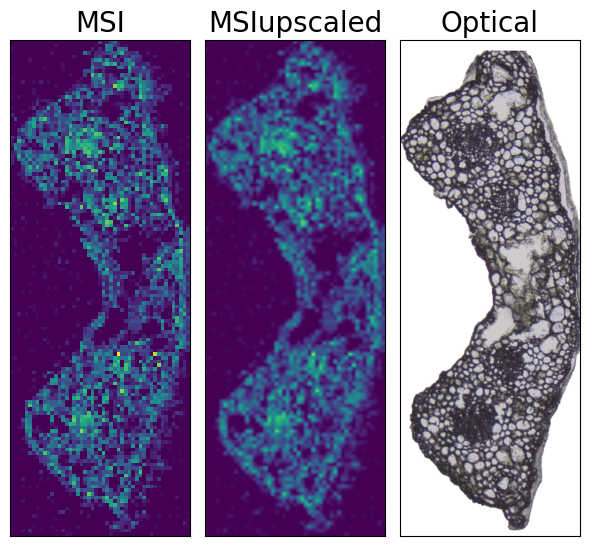

 17%|█▋        | 331/2000 [01:00<05:07,  5.43it/s]


Early stop at: Epoch [332/2000], Loss: 5.2064
             0          1          2          3         4         5    \
loss1  13.877052  11.194245  10.563868  10.047512  9.549119  9.077658   
loss2  20.084053   6.345800   3.070029   2.227080  1.862784  1.671306   
loss   13.877052  11.194245  10.563868  10.047512  9.549119  9.077658   

            6         7         8         9    ...       321       322  \
loss1  8.635821  8.263369  7.947321  7.626904  ...  4.433768  4.431271   
loss2  1.565267  1.461597  1.465010  1.407971  ...  0.040493  0.039687   
loss   8.635821  8.263369  7.947321  7.626904  ...  5.243620  5.225009   

            323       324       325       326       327       328       329  \
loss1  4.428647  4.427479  4.426867  4.427222  4.427782  4.428120  4.428667   
loss2  0.039810  0.039862  0.039694  0.039318  0.039151  0.039274  0.038900   
loss   5.224839  5.224721  5.220748  5.213584  5.210805  5.213596  5.206674   

            330  
loss1  4.427452  
loss2  0.03

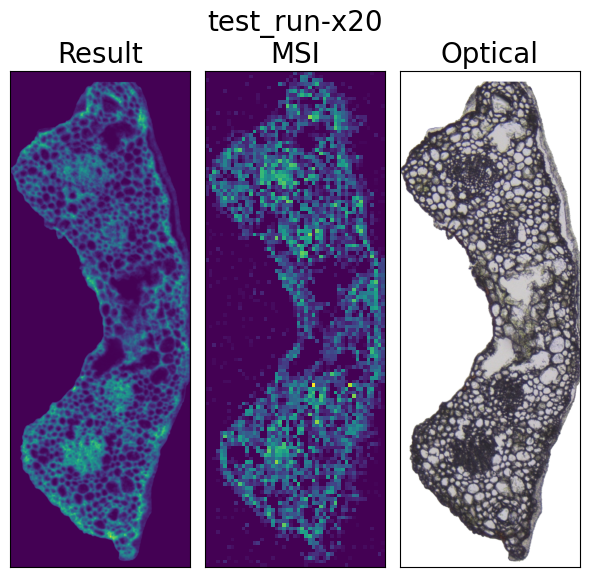

In [14]:
# test run
# device is always 0 for single GPU user. For multi-GPU user, specify the GPU number.
# this test run was done on a different device. 

model = RES()
runname = 'test_run'
factor = 20
device = 0
edge_pat_w(model, msi_data
                , runname=runname
                , device=device
                , factor=factor
                , num_epochs=2000
                , interval_epochs=500
                , lr=0.0003
                , initial_patience=10
                , weight = 20
                , return_=False
                )